# Chernobyl bank voles colon RNAseq study - gut microbiome part

The total data set include 45 bank vole individuals, the EMP primer pair was used to sequence these samples at BGI on the HiSeq 2500 platform in a PE250bp mode (note that the quality scores for the data are at Phred64, as it is Illumina 1.5). Of important note, the read data are free of adapters and primers. These, including any other sequencing constucts were removed as a part of the sequencing facility service, so NO additional trimming from the left needed.

EMP primer pair
*F515* 5'-GTGCCAGCMGCCGCGGTAA-3'
*R806* 5'-GGACTACHVGGGTWTCTAAT-3'

I will also rename all the files from .fq to .fastq using the following script:

rename '.fq' '.fastq' *.fq

I will also compress a fastq files in gzip format (raw BGI data and also post PEAR assembled data), first it is what q2 recommend (though, not require) for the data import. Second, this allow to compress the data and save up to ~x5 storage space.

gzip *.fastq

### dada2 data import
I will import paired-end data (raw from BGI) to use with dada2 in qiime2

In [ ]:
!qiime tools import \
    --type 'SampleData[PairedEndSequencesWithQuality]' \
    --input-path manifest-dada2-transcript-microbes.txt \
    --input-format PairedEndFastqManifestPhred64 \
    --output-path dada2-rna/dada2-trans-microbe-demux.qza

### deblur data import

I will make use of pre-joined read data I have previously assembled on 02.01.2018:

I run PEAR with default settings (except change of Phred score for 64 using the following argument: b 64) and after that I was using the following command to examine reads length distribution:

cat R17_FCH3NWKBCX2_L2_WHMYOegcMAaA-10-52.assembled.fastq | awk '{if(NR%4==2) print length($1)}' | sort -n | uniq -c > read_length_mnR17.txt

It appears that most of the reads are in between 252-254 bp long, so I was using the following command to run PEAR and specified minimum (-n 252) and maximum (-m 254) length of merged reads.
The full script is at pear_transcript_microbiome.bash file, minimum example is below:

pear -f /wrk/lava/DONOTREMOVE/transcript_microbe/R17_FCH3NWKBCX2_L2_WHMYOegcMAaA-10-52_1.fq -r /wrk/lava/DONOTREMOVE/transcript_microbe/R17_FCH3NWKBCX2_L2_WHMYOegcMAaA-10-52_2.fq -o /wrk/lava/DONOTREMOVE/transcript_microbe/pear_output_trmic/R17_FCH3NWKBCX2_L2_WHMYOegcMAaA-10-52 -b 64 -m 254 -n 252

In [ ]:
!qiime tools import \
  --input-path manifest-deblur-transcript-microbes.txt \
  --output-path deblur_rna/deblur-trans-microbe-demux.qza \
  --type SampleData[JoinedSequencesWithQuality] \
  --input-format SingleEndFastqManifestPhred64

### dada2 & deblur demux summarize

The fastq files were successfully imported into the working directories. qiime2 have 2 main data semantic types: .qza (data artifact) and .qzv (data visualization artifact). We would want to summarize and visualize the data (imported into qiime2 .qza file).

In [ ]:
!qiime demux summarize \
--i-data dada2-rna/dada2-trans-microbe-demux.qza \
--o-visualization dada2-rna/dada2-trans-microbe-demux.qzv

In [ ]:
!qiime demux summarize \
  --i-data deblur-rna/deblur-trans-microbe-demux.qza \
  --o-visualization deblur-rna/deblur-trans-microbe-demux.qzv

## denoising: amplicon sequence variants (ASV's) picking


### dada2

Examine the interactive quality plots, they display the reads quality in defined position according to the Phred33 (converted from Phred64 in this case) qc format. The median quality score for both forward and reverse reads keeps over 35, however we also observe some quality drop in the end of the reverse reads. Overall, based on the posts [here](https://forum.qiime2.org/t/dada2-trimming-values-for-pair-end-sequences/3458) and [here](https://forum.qiime2.org/t/dada2-truncation-lengths-and-features-number/1940/6), these data look fairly good and only require some quality based trimming. We can leave the forward reads as it is (250 bp), but apply *truncation-len-r* for the reverse reads at the position 186. In this case, the lowest quality at the bottom of the box will be >20.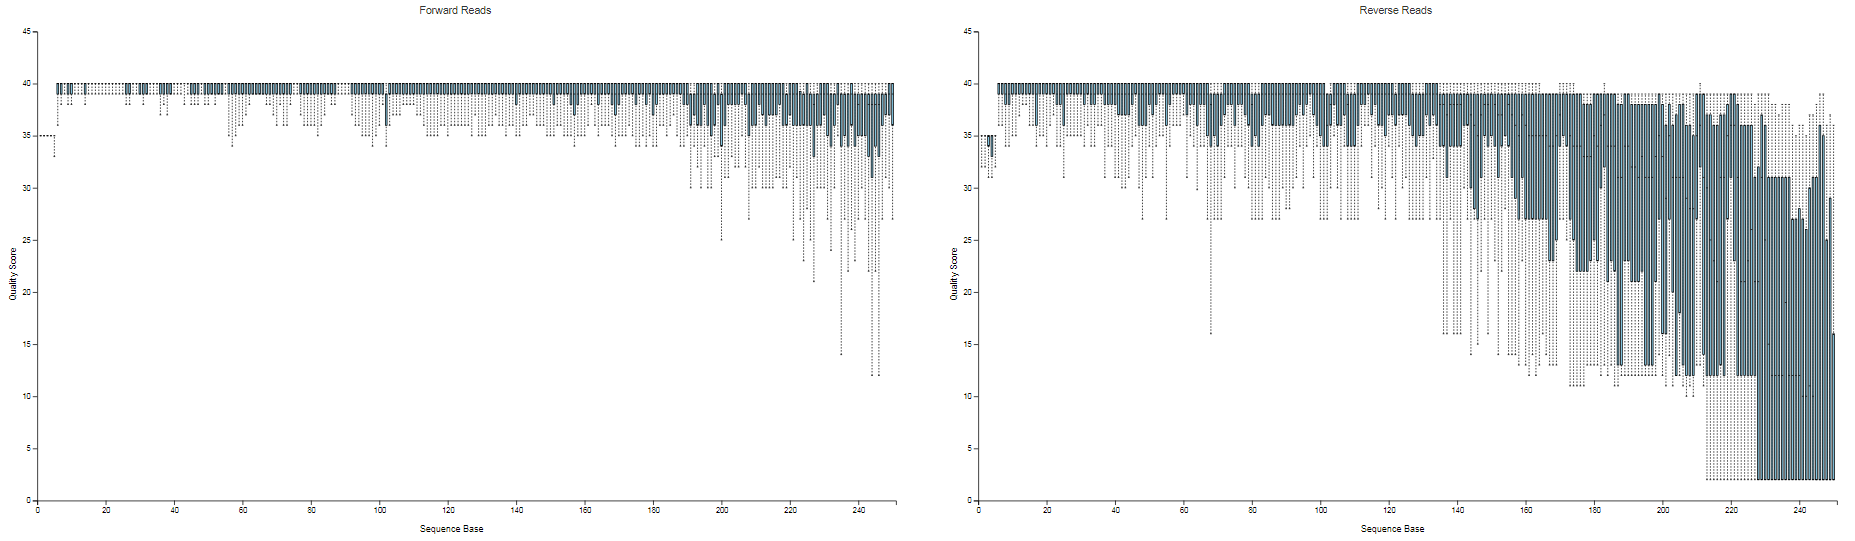

!Note that this (denoising with dada2) was REALLY SLOW! It took ~46 to run @CSC... 

In [ ]:
!qiime dada2 denoise-paired \
    --i-demultiplexed-seqs dada2-rna/dada2-trans-microbe-demux.qza \
    --p-trim-left-f 0 \
    --p-trunc-len-f 250 \
    --p-trim-left-r 0 \
    --p-trunc-len-r 186 \
    --p-n-threads 0 \
    --o-representative-sequences dada2-rna/dada2-trans-microbe-rep-seqs.qza \
    --o-denoising-stats dada2-rna/dada2-trans-microbe-stats.qza \
    --o-table dada2-rna/dada2-trans-microbe-table.qza

In [ ]:
#Add metadata and examine count tables generated by deblur

!qiime feature-table summarize \
  --i-table dada2-rna/dada2-trans-microbe-table.qza \
  --o-visualization dada2-rna/dada2-trans-microbe-table.qzv \
  --m-sample-metadata-file metadata-transcript-microbe.txt

#Examine representative sequences
!qiime feature-table tabulate-seqs \
 --i-data dada2-rna/dada2-trans-microbe-rep-seqs.qza \
 --o-visualization dada2-rna/dada2-trans-microbe-rep-seqs.qzv

### deblur

We will also run [Deblur](https://docs.qiime2.org/2018.2/plugins/available/deblur/denoise-16S/) to compare performance of these two denoisers and choose the one we will use for the downstream analysis.

#### Merging pair-end data

Deblur only uses forward reads at this time. Hence, prior to run Deblur, we would need to merge your data with some qiime2 tools OR (as described below) by importing your data as single-end reads. In this case data needs to be pre-joined outside of the qiime2 (for more details, see doc's [here](https://docs.qiime2.org/2018.2/tutorials/read-joining/#importing-pre-joined-reads)), for example, with [PEAR](https://sco.h-its.org/exelixis/web/software/pear/). See details for the input demux data above...

The importing data quality scores are SUPERB (minimal shared reads length is 252), so we can now use these pre-assembeled samples in the deblur workflow.

In [ ]:
#To speed-up the process, you can make use of paralization of the jobs @CSC.
#Provide --p-jobs-to-start 20 (or other number).

!qiime deblur denoise-16S \
  --i-demultiplexed-seqs deblur-rna/deblur-trans-microbe-demux.qza \
  --p-trim-length 252 \
  --o-representative-sequences deblur-rna/deblur-trans-microbe-rep-seqs.qza \
  --o-table deblur-rna/deblur-trans-microbe-table.qza \
  --p-sample-stats \
  --o-stats deblur-rna/deblur-trans-microbe-stats.qza

We would now want to add metadata and examine count tables generated by the direct deblur analysis on the pre-assembled (with PEAR) forward and reverse reads.

In [ ]:
#Add metadata and examine count tables generated by deblur

!qiime feature-table summarize \
  --i-table deblur-rna/deblur-trans-microbe-table.qza \
  --o-visualization deblur-rna/deblur-trans-microbe-table.qzv \
  --m-sample-metadata-file metadata-transcript-microbe.txt

#Examine representative sequences
!qiime feature-table tabulate-seqs \
 --i-data deblur-rna/deblur-trans-microbe-rep-seqs.qza \
 --o-visualization deblur-rna/deblur-trans-microbe-rep-seqs.qzv

I will also create a phylogenetic tree for the downstream use with phylogeny-based metrics.

In [ ]:
#Multiple sequence alignment: MAFFT is used for multiple sequences alignment

!qiime alignment mafft \
  --i-sequences dada2-rna/dada2-trans-microbe-rep-seqs.qza \
  --o-alignment dada2-rna/aligned-dada2-trans-microbe-rep-seqs.qza

#Masking sites: mask (or filter) the alignment to remove positions that are highly variable
#These positions are generally considered to add noise to a resulting phylogenetic tree

!qiime alignment mask \
  --i-alignment dada2-rna/aligned-dada2-trans-microbe-rep-seqs.qza \
  --o-masked-alignment dada2-rna/masked-aligned-dada2-trans-microbe-rep-seqs.qza

#Creating a tree: Fastree is used to generate a phylogenetic tree from the masked alignment

!qiime phylogeny fasttree \
  --i-alignment dada2-rna/masked-aligned-dada2-trans-microbe-rep-seqs.qza \
  --o-tree dada2-rna/unrooted-tree-dada2-trans-microbe.qza

#Midpoint rooting: Fastree creates an unrooted tree. We can root the tree at it’s midpoint with this command:

!qiime phylogeny midpoint-root \
  --i-tree dada2-rna/unrooted-tree-dada2-trans-microbe.qza \
  --o-rooted-tree dada2-rna/rooted-tree-dada2-trans-microbe.qza

In [ ]:
#Multiple sequence alignment: MAFFT is used for multiple sequences alignment

!qiime alignment mafft \
  --i-sequences deblur-rna/deblur-trans-microbe-rep-seqs.qza \
  --o-alignment deblur-rna/aligned-deblur-trans-microbe-rep-seqs.qza

#Masking sites: mask (or filter) the alignment to remove positions that are highly variable
#These positions are generally considered to add noise to a resulting phylogenetic tree

!qiime alignment mask \
  --i-alignment deblur-rna/aligned-deblur-trans-microbe-rep-seqs.qza \
  --o-masked-alignment deblur-rna/masked-aligned-deblur-trans-microbe-rep-seqs.qza

#Creating a tree: Fastree is used to generate a phylogenetic tree from the masked alignment

!qiime phylogeny fasttree \
  --i-alignment deblur-rna/masked-aligned-deblur-trans-microbe-rep-seqs.qza \
  --o-tree deblur-rna/unrooted-tree-deblur-trans-microbe.qza

#Midpoint rooting: Fastree creates an unrooted tree. We can root the tree at it’s midpoint with this command:

!qiime phylogeny midpoint-root \
  --i-tree deblur-rna/unrooted-tree-deblur-trans-microbe.qza \
  --o-rooted-tree deblur-rna/rooted-tree-deblur-trans-microbe.qza

I will now (19.12.18) filter out low abundance features (<10 reads) from the feature tables to reduce noise in the dataset. I would have to filter only the dada2 generated table, as deblur default parameters: min_reads:10 - the features in the deblur table have minimum of 10 reads (frequency of 10) for support.

In [ ]:
#Filter features with the frequency less than 10

!qiime feature-table filter-features \
  --i-table dada2-rna/dada2-trans-microbe-table.qza \
  --p-min-frequency 10 \
  --o-filtered-table dada2-rna/dada2-trans-microbe-filtered10-table.qza

In [ ]:
#Summarize filtered10 feature table

!qiime feature-table summarize \
  --i-table dada2-rna/dada2-trans-microbe-filtered10-table.qza \
  --o-visualization dada2-rna/dada2-trans-microbe-filtered10-table.qzv \
  --m-sample-metadata-file metadata-transcript-microbe.txt

## rarefaction curve to examine diversity coverage

We would need use the maximum number of reads per sample present in the (FILTERED10 dada2)dataset to duild a rarefaction curve.
Based on the deblur table max reads/sample - 111,529
Based on the dada2 filtered10 table max reads/sample - 137,640

In [ ]:
!qiime diversity alpha-rarefaction \
 --i-table dada2-rna/dada2-trans-microbe-filtered10-table.qza \
 --i-phylogeny dada2-rna/rooted-tree-dada2-trans-microbe.qza \
 --p-max-depth 137640 \
 --p-metrics faith_pd \
 --p-metrics shannon \
 --p-metrics observed_otus \
 --p-metrics chao1 \
 --m-metadata-file metadata-transcript-microbe.txt \
 --o-visualization dada2-rna/alpha-rare-dada2-filtered10-trans-microbe.qzv

In [ ]:
!qiime diversity alpha-rarefaction \
 --i-table deblur-rna/deblur-trans-microbe-table.qza \
 --i-phylogeny deblur-rna/rooted-tree-deblur-trans-microbe.qza \
 --p-max-depth 111529 \
 --p-metrics faith_pd \
 --p-metrics shannon \
 --p-metrics observed_otus \
 --p-metrics chao1 \
 --m-metadata-file metadata-transcript-microbe.txt \
 --o-visualization deblur-rna/alpha-rare-deblur-trans-microbe.qzv

Based on the alpha-rarefaction curves generated from both dada2 and deblur feature tables, it is clear that our sequencing effort covers most of the gut microbiome community members associated with sampled bank voles. The dada2 data level off well before the ~20K reads based on the observed OTUs metric, whereas the deblur data is on s gradual rise up to the ~45-50K reads.

Given that the minimum read number per sample is these datasets is: filtered10-dada2 74,172 reads/sample; deblur 53,311 reads/sample; we can retain all the samples, rarefying the datasets at the 74,172 and 53,311 reads/sample, respectively (minimal amount in a given sample within the data set).

Here I will run the core-metrics-phylogenetic pipeline to produce basic alpha and beta diversity measures. The dada2 and deblur tables will be rarefied during this procedure in a respective sequencing depth as discussed above.

In [ ]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny dada2-rna/rooted-tree-dada2-trans-microbe.qza \
  --i-table dada2-rna/dada2-trans-microbe-filtered10-table.qza \
  --p-sampling-depth 74172 \
  --m-metadata-file metadata-transcript-microbe.txt \
  --output-dir dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/  

In [ ]:
!qiime diversity core-metrics-phylogenetic \
  --i-phylogeny deblur-rna/rooted-tree-deblur-trans-microbe.qza \
  --i-table deblur-rna/deblur-trans-microbe-table.qza \
  --p-sampling-depth 53311 \
  --m-metadata-file metadata-transcript-microbe.txt \
  --output-dir deblur-rna/core-metrics-trans-microbe-deblur-results/  

For further convinience, I will rename all the files within the core-metrics-phylogenetic directories by adding the respective -dada2 or -deblur to the file name with the following scripts:
rename '.qza' 'trans_microbe_dada2.qza' *.qza
rename '.qzv' 'trans_microbe_dada2.qzv' *.qzv
rename '.qza' 'trans_microbe_deblur.qza' *.qza
rename '.qzv' 'trans_microbe_deblur.qzv' *.qzv

## alpha diversity significance analysis

In [ ]:
#Observed 'OTUs'-single nucleotide variances counts

!qiime diversity alpha-group-significance \
  --i-alpha-diversity dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/observed_otus_vectortrans_microbe_dada2.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --o-visualization dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/observed_otus_trans_microbe_dada2-group-significance.qzv

#Faith phylogenetic diversity    
    
!qiime diversity alpha-group-significance \
  --i-alpha-diversity dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/faith_pd_vectortrans_microbe_dada2.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --o-visualization dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/faith_pd_trans_microbe_dada2-group-significance.qzv

#Shannon Index  
    
!qiime diversity alpha-group-significance \
  --i-alpha-diversity dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/shannon_vectortrans_microbe_dada2.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --o-visualization dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/shannon_trans_microbe_dada2-group-significance.qzv

I will do the same now for the deblur dataset as well.

In [ ]:
#Observed 'OTUs'-single nucleotide variances counts

!qiime diversity alpha-group-significance \
  --i-alpha-diversity deblur-rna/core-metrics-trans-microbe-deblur-results/observed_otus_vectortrans_microbe_deblur.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --o-visualization deblur-rna/core-metrics-trans-microbe-deblur-results/observed_otus_trans_microbe_deblur-group-significance.qzv

#Faith phylogenetic diversity    
    
!qiime diversity alpha-group-significance \
  --i-alpha-diversity deblur-rna/core-metrics-trans-microbe-deblur-results/faith_pd_vectortrans_microbe_deblur.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --o-visualization deblur-rna/core-metrics-trans-microbe-deblur-results/faith_pd_trans_microbe_deblur-group-significance.qzv

#Shannon Index  
    
!qiime diversity alpha-group-significance \
  --i-alpha-diversity deblur-rna/core-metrics-trans-microbe-deblur-results/shannon_vectortrans_microbe_deblur.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --o-visualization deblur-rna/core-metrics-trans-microbe-deblur-results/shannon_trans_microbe_deblur-group-significance.qzv

## beta diversity analysis

In [ ]:
!qiime diversity beta-group-significance \
  --i-distance-matrix dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/unweighted_unifrac_distance_matrixtrans_microbe_dada2.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --m-metadata-column Geography \
  --o-visualization dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/unweighted_unifrac_trans_microbe_dada2-significance-geography.qza \
  --p-pairwise   

In [ ]:
!qiime diversity beta-group-significance \
  --i-distance-matrix deblur-rna/core-metrics-trans-microbe-deblur-results/unweighted_unifrac_distance_matrixtrans_microbe_deblur.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --m-metadata-column Geography \
  --o-visualization deblur-rna/core-metrics-trans-microbe-deblur-results/unweighted_unifrac_trans_microbe_deblur-significance-geography.qza \
  --p-pairwise  

## taxonomic analysis

Upload the GreenGenes 'reference data base'. This is a pre-trained Naive Bayes classifier and the q2-feature-classifier plugin. This classifier was trained on the Greengenes 13_8 99% OTUs, where the sequences have been trimmed to only include 250 bases from the region of the 16S that was sequenced in this analysis (the V4 region, bound by the 515F/806R EMP primer pair). We’ll apply this classifier to our sequences, and we can generate a visualization of the resulting mapping from sequence to taxonomy. See more information of the pre-trained classifiers [here](https://docs.qiime2.org/2018.2/data-resources/)

In [ ]:
!wget -O "gg-13-8-99-515-806-nb-classifier.qza" "https://data.qiime2.org/2018.2/common/gg-13-8-99-515-806-nb-classifier.qza"

In [ ]:
!qiime feature-classifier classify-sklearn \
  --i-classifier gg-13-8-99-515-806-nb-classifier.qza \
  --i-reads dada2-rna/dada2-trans-microbe-rep-seqs.qza \
  --o-classification dada2-rna/dada2-trans-microbe-taxonomy.qza

!qiime metadata tabulate \
  --m-input-file dada2-rna/dada2-trans-microbe-taxonomy.qza \
  --o-visualization dada2-rna/dada2-trans-microbe-taxonomy.qzv

In [ ]:
!qiime feature-classifier classify-sklearn \
  --i-classifier gg-13-8-99-515-806-nb-classifier.qza \
  --i-reads deblur-rna/deblur-trans-microbe-rep-seqs.qza \
  --o-classification deblur-rna/deblur-trans-microbe-taxonomy.qza

!qiime metadata tabulate \
  --m-input-file deblur-rna/deblur-trans-microbe-taxonomy.qza \
  --o-visualization deblur-rna/deblur-trans-microbe-taxonomy.qzv

Next, we can view the taxonomic composition of our samples with interactive bar plots. I will generate those plots with the following command and then open the visualization.

In [ ]:
#GreenGenes - dada2
#Note, this bar plot was based on the non-rarefied feature table.. the rarefied (from the core-metrics-phylogenetic plugin)
#table was use for the relative frequency data generated below

!qiime taxa barplot \
  --i-table dada2-rna/dada2-trans-microbe-filtered10-table.qza \
  --i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --o-visualization dada2-rna/dada2-trans-microbe-taxa-bar-plots.qzv

#GreenGenes - deblur

!qiime taxa barplot \
  --i-table deblur-rna/deblur-trans-microbe-table.qza \
  --i-taxonomy deblur-rna/deblur-trans-microbe-taxonomy.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --o-visualization deblur-rna/deblur-trans-microbe-taxa-bar-plots.qzv

Overall the dada2 and deblur datasets looked very similar and only fine scale difference patterns were evident (slioght increase/decrease in some taxa over the taxonomy bar plots; samples were slightly shifted around on ordination). However, I think that doesn't really matter which of the two denoising methods I will use, as both were so similar. Thought, given that the more reads survived through the dada2, I will use the filtered10-dada2 table throught the analysis.

### relative frequency dada2 tables
Here I will generate the tables with relative abundance data at several taxanomical levels (L2 phylum, L3 class, L4 order, L5 family, L6 genus, L7 species). These are based on the filtered10, even (rarefied at 74172 reads/sample) dada2 denoised dataset.

In [ ]:
!qiime taxa collapse \
--i-table dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/rarefied_tabletrans_microbe_dada2.qza  \
--i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
--p-level 2 \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L2-filtered10-even-dada2

In [ ]:
!qiime feature-table relative-frequency \
--i-table dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L2-filtered10-even-dada2/collapsedL2_table.qza \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L2-filtered10-even-dada2/relative-L2-dada2

In [ ]:
!qiime taxa collapse \
--i-table dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/rarefied_tabletrans_microbe_dada2.qza  \
--i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
--p-level 3 \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L3-filtered10-even-dada2

In [ ]:
!qiime feature-table relative-frequency \
--i-table dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L3-filtered10-even-dada2/collapsedL3_table.qza \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L3-filtered10-even-dada2/relative-L3-dada2

In [ ]:
!qiime taxa collapse \
--i-table dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/rarefied_tabletrans_microbe_dada2.qza  \
--i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
--p-level 4 \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L4-filtered10-even-dada2

In [ ]:
!qiime feature-table relative-frequency \
--i-table dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L4-filtered10-even-dada2/collapsedL4_table.qza \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L4-filtered10-even-dada2/relative-L4-dada2

In [ ]:
!qiime taxa collapse \
--i-table dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/rarefied_tabletrans_microbe_dada2.qza \
--i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
--p-level 5 \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L5-filtered10-even-dada2

In [ ]:
!qiime feature-table relative-frequency \
--i-table dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L5-filtered10-even-dada2/collapsedL5_table.qza \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L5-filtered10-even-dada2/relative-L5-dada2

In [ ]:
!qiime taxa collapse \
--i-table dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/rarefied_tabletrans_microbe_dada2.qza \
--i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
--p-level 6 \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L6-filtered10-even-dada2

In [ ]:
!qiime feature-table relative-frequency \
--i-table dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L6-filtered10-even-dada2/collapsedL6_table.qza \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L6-filtered10-even-dada2/relative-L6-dada2

In [ ]:
!qiime taxa collapse \
--i-table dada2-rna/core-metrics-trans-microbe-dada2-filtered10-results/rarefied_tabletrans_microbe_dada2.qza \
--i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
--p-level 7 \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L7-filtered10-even-dada2

In [ ]:
!qiime feature-table relative-frequency \
--i-table dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L7-filtered10-even-dada2/collapsedL7_table.qza \
--output-dir dada2-rna/taxa-relative-filtered10-even-dada2/collapsed-L7-filtered10-even-dada2/relative-L7-dada2

I would have to convert the biom tables to tsv prior merging all the metadata into one file containing the taxonomy and the other data associated with each bank vole individual.

In [ ]:
#Open the relative-frequency_table.qza with any zip archive app and export biom table,
#move it back to taito and run the following:
module load qiime/1.9.1
biom convert -i feature-tableL2.biom -o feature-tableL2.tsv --to-tsv
biom convert -i feature-tableL3.biom -o feature-tableL3.tsv --to-tsv
biom convert -i feature-tableL4.biom -o feature-tableL4.tsv --to-tsv
biom convert -i feature-tableL5.biom -o feature-tableL5.tsv --to-tsv
biom convert -i feature-tableL6.biom -o feature-tableL6.tsv --to-tsv
biom convert -i feature-tableL7.biom -o feature-tableL7.tsv --to-tsv

#Open the generated tsv file and voila, all the features are in relative abundances per sample (sample id),
#proceed with the analysis...
#These relative abundance values will be included into the fila metadata file for the colon RNAseq animals!

## balance trees analysis - gneiss plugin within the qiime2 (08042019)

I will apply the contingency-based filtering to the original (non-rarefied!!!) dada2 feature-table, and exclude features that are found in less than 5 (and later, also in less than 15) samples. This will allow us to redice noise by filtering low abundance features and features that are rarely found in the dataset.

In [1]:
#Filter features that are present in less than 5 samples
!qiime feature-table filter-features \
  --i-table dada2-rna/dada2-trans-microbe-table.qza \
  --p-min-samples 5 \
  --o-filtered-table dada2-rna/dada2-trans-microbe-smpl5-table.qza
  
#Summarize filtered feature table
!qiime feature-table summarize \
  --i-table dada2-rna/dada2-trans-microbe-smpl5-table.qza \
  --o-visualization dada2-rna/dada2-trans-microbe-smpl5-table.qzv \
  --m-sample-metadata-file metadata-transcript-microbe.txt

Saved FeatureTable[Frequency] to: dada2-rna/dada2-trans-microbe-smpl5-table.qza
Saved Visualization to: dada2-rna/dada2-trans-microbe-smpl5-table.qzv


In [2]:
!qiime gneiss correlation-clustering \
  --i-table dada2-rna/dada2-trans-microbe-smpl5-table.qza \
  --o-clustering dada2-rna/balance-trees-smpl5/hierarchy.qza
  
!qiime gneiss ilr-hierarchical \
  --i-table dada2-rna/dada2-trans-microbe-smpl5-table.qza \
  --i-tree dada2-rna/balance-trees-smpl5/hierarchy.qza \
  --o-balances dada2-rna/balance-trees-smpl5/balances.qza

Saved Hierarchy to: dada2-rna/balance-trees-smpl5/hierarchy.qza
Saved FeatureTable[Balance] to: dada2-rna/balance-trees-smpl5/balances.qza


In [3]:
!qiime gneiss ols-regression \
  --p-formula "Geography" \
  --i-table dada2-rna/balance-trees-smpl5/balances.qza \
  --i-tree dada2-rna/balance-trees-smpl5/hierarchy.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --o-visualization dada2-rna/balance-trees-smpl5/regression_summary.qzv

Saved Visualization to: dada2-rna/balance-trees-smpl5/regression_summary.qzv


In [4]:
!qiime gneiss dendrogram-heatmap \
  --i-table dada2-rna/dada2-trans-microbe-smpl5-table.qza \
  --i-tree dada2-rna/balance-trees-smpl5/hierarchy.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --m-metadata-column Geography \
  --p-color-map viridis \
  --o-visualization dada2-rna/balance-trees-smpl5/heatmap-virdis.qzv

Saved Visualization to: dada2-rna/balance-trees-smpl5/heatmap-virdis.qzv


In [5]:
!qiime gneiss balance-taxonomy \
  --i-table dada2-rna/dada2-trans-microbe-smpl5-table.qza \
  --i-tree dada2-rna/balance-trees-smpl5/hierarchy.qza \
  --i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
  --p-taxa-level 4 \
  --p-balance-name 'y0' \
  --m-metadata-file metadata-transcript-microbe.txt \
  --m-metadata-column Geography \
  --o-visualization dada2-rna/balance-trees-smpl5/y0_taxa_summaryL4.qzv

Saved Visualization to: dada2-rna/balance-trees-smpl5/y0_taxa_summaryL4.qzv


In [6]:
!qiime gneiss balance-taxonomy \
  --i-table dada2-rna/dada2-trans-microbe-smpl5-table.qza \
  --i-tree dada2-rna/balance-trees-smpl5/hierarchy.qza \
  --i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
  --p-taxa-level 3 \
  --p-balance-name 'y0' \
  --m-metadata-file metadata-transcript-microbe.txt \
  --m-metadata-column Geography \
  --o-visualization dada2-rna/balance-trees-smpl5/y0_taxa_summaryL3.qzv

Saved Visualization to: dada2-rna/balance-trees-smpl5/y0_taxa_summaryL3.qzv


I will try to reduce number of features by filtering all the features found in less than 10 samples. This might help with the sparce read data distribution within the dataset.

In [9]:
#Filter features that are present in less than 15 samples
!qiime feature-table filter-features \
  --i-table dada2-rna/dada2-trans-microbe-table.qza \
  --p-min-samples 15 \
  --o-filtered-table dada2-rna/dada2-trans-microbe-smpl15-table.qza
  
#Summarize filtered feature table
!qiime feature-table summarize \
  --i-table dada2-rna/dada2-trans-microbe-smpl15-table.qza \
  --o-visualization dada2-rna/dada2-trans-microbe-smpl15-table.qzv \
  --m-sample-metadata-file metadata-transcript-microbe.txt

Saved FeatureTable[Frequency] to: dada2-rna/dada2-trans-microbe-smpl15-table.qza
Saved Visualization to: dada2-rna/dada2-trans-microbe-smpl15-table.qzv


In [12]:
!qiime gneiss correlation-clustering \
  --i-table dada2-rna/dada2-trans-microbe-smpl15-table.qza \
  --o-clustering dada2-rna/balance-trees-smpl15/hierarchy.qza
  
!qiime gneiss ilr-hierarchical \
  --i-table dada2-rna/dada2-trans-microbe-smpl15-table.qza \
  --i-tree dada2-rna/balance-trees-smpl15/hierarchy.qza \
  --o-balances dada2-rna/balance-trees-smpl15/balances.qza

Saved Hierarchy to: dada2-rna/balance-trees-smpl15/hierarchy.qza
Saved FeatureTable[Balance] to: dada2-rna/balance-trees-smpl15/balances.qza


In [13]:
!qiime gneiss ols-regression \
  --p-formula "Geography" \
  --i-table dada2-rna/balance-trees-smpl15/balances.qza \
  --i-tree dada2-rna/balance-trees-smpl15/hierarchy.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --o-visualization dada2-rna/balance-trees-smpl15/regression_summary.qzv

!qiime gneiss dendrogram-heatmap \
  --i-table dada2-rna/dada2-trans-microbe-smpl15-table.qza \
  --i-tree dada2-rna/balance-trees-smpl15/hierarchy.qza \
  --m-metadata-file metadata-transcript-microbe.txt \
  --m-metadata-column Geography \
  --p-color-map viridis \
  --o-visualization dada2-rna/balance-trees-smpl15/heatmap-virdis.qzv

Saved Visualization to: dada2-rna/balance-trees-smpl15/regression_summary.qzv
Saved Visualization to: dada2-rna/balance-trees-smpl15/heatmap-virdis.qzv


In [14]:
  !qiime gneiss balance-taxonomy \
  --i-table dada2-rna/dada2-trans-microbe-smpl15-table.qza \
  --i-tree dada2-rna/balance-trees-smpl15/hierarchy.qza \
  --i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
  --p-taxa-level 4 \
  --p-balance-name 'y0' \
  --m-metadata-file metadata-transcript-microbe.txt \
  --m-metadata-column Geography \
  --o-visualization dada2-rna/balance-trees-smpl15/y0_taxa_summaryL4.qzv

Saved Visualization to: dada2-rna/balance-trees-smpl15/y0_taxa_summaryL4.qzv


In [15]:
  !qiime gneiss balance-taxonomy \
  --i-table dada2-rna/dada2-trans-microbe-smpl15-table.qza \
  --i-tree dada2-rna/balance-trees-smpl15/hierarchy.qza \
  --i-taxonomy dada2-rna/dada2-trans-microbe-taxonomy.qza \
  --p-taxa-level 4 \
  --p-balance-name 'y1' \
  --m-metadata-file metadata-transcript-microbe.txt \
  --m-metadata-column Geography \
  --o-visualization dada2-rna/balance-trees-smpl15/y1_taxa_summaryL4.qzv

Saved Visualization to: dada2-rna/balance-trees-smpl15/y1_taxa_summaryL4.qzv
